<a href="https://colab.research.google.com/github/Ofiregev/-cowboy_vs_ninja_a/blob/master/Fetal_Cns_Final_reg_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:

# Read CSV file
train_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC.csv"
train_csv_df = pd.read_csv(train_csv)
print("CSV file loaded:")
print(train_csv_df.head())

# Normalize the labels in the dataset
min_hc = train_csv_df['head circumference (mm)'].min()
max_hc = train_csv_df['head circumference (mm)'].max()
train_csv_df['Normalized_HC'] = (train_csv_df['head circumference (mm)'] - min_hc) / (max_hc - min_hc)
output_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC_no_index.csv"
train_csv_df.to_csv(output_csv, index=False)
print("Normalized CSV file saved.")
print(train_csv_df.head())

# Image Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CSV file loaded:
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81
Normalized CSV file saved.
     filename  pixel size(mm)  head circumference (mm)  Normalized_HC
0  000_HC.png        0.069136                    44.30       0.000000
1  001_HC.png        0.089659                    56.81       0.041410
2  002_HC.png        0.062033                    68.75       0.080933
3  003_HC.png        0.091291                    69.00       0.081761
4  004_HC.png        0.061240                    59.81       0.051341


In [4]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        hc = self.data_frame.iloc[idx, -1]  # Normalized head circumference

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(hc, dtype=torch.float)

In [5]:


# Dataset and DataLoader
csv_file = output_csv
root_dir = "/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/"
dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [35]:


# Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x)

model = CNNModel().to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Plot Loss Function
def plot_loss(train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [36]:
import matplotlib.pyplot as plt

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, hcs in train_loader:
            images, hcs = images.to(device), hcs.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, hcs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, hcs in val_loader:
                images, hcs = images.to(device), hcs.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, hcs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    print("Training complete")

    # Plot the loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

Epoch [1/10], Loss: 0.4103, Val Loss: 0.2336
Epoch [2/10], Loss: 0.0257, Val Loss: 0.0233
Epoch [3/10], Loss: 0.0118, Val Loss: 0.0136
Epoch [4/10], Loss: 0.0120, Val Loss: 0.0082
Epoch [5/10], Loss: 0.0117, Val Loss: 0.0134
Epoch [6/10], Loss: 0.0100, Val Loss: 0.0057
Epoch [7/10], Loss: 0.0100, Val Loss: 0.0063
Epoch [8/10], Loss: 0.0068, Val Loss: 0.0062
Epoch [9/10], Loss: 0.0054, Val Loss: 0.0062
Epoch [10/10], Loss: 0.0084, Val Loss: 0.0097
Training complete


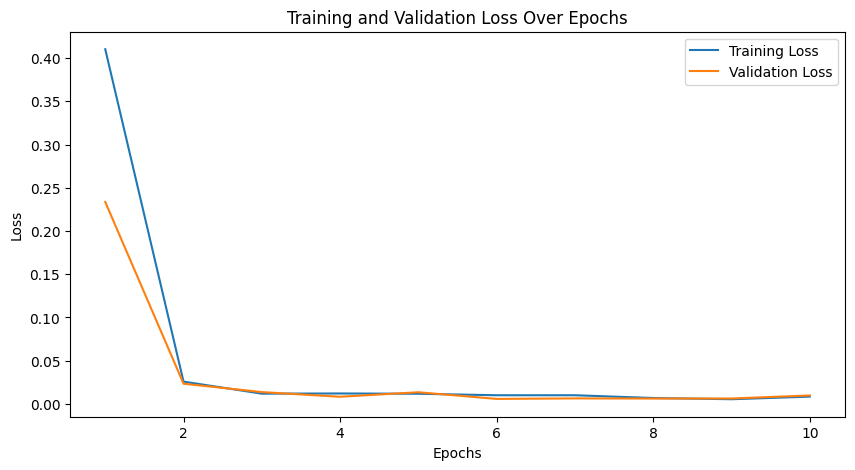

In [37]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)



In [38]:
# Save the model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/FinalProject/trained_model.pth


In [39]:
# Load the trained model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully")

Model loaded successfully


In [50]:
def predict_head_circumference(image_path, model, min_hc, max_hc):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predicted_normalized_hc = model(image).item()
        predicted_hc = predicted_normalized_hc * (max_hc - min_hc) + min_hc  # De-normalize the prediction

    return predicted_hc

In [51]:
# Evaluate the model on the entire training set
min_hc = train_csv_df['head circumference (mm)'].min()
max_hc = train_csv_df['head circumference (mm)'].max()
num_images_to_test = len(train_csv_df)
indices = range(num_images_to_test)  # Generate a sequence of indices from 0 to num_images_to_test-1

# Initialize a list to store the results
results = []
absolute_errors = []
counter = 0
error_parameter = 5

# Loop through the selected images
for idx in indices:
    image_name = train_csv_df.iloc[idx, 0]
    image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", image_name)
    ground_truth_circumference = train_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels

    # Call the function to predict head circumference from the image
    predicted_circumference = predict_head_circumference(image_path, model, min_hc, max_hc)

    # Calculate the absolute error
    absolute_error = abs(predicted_circumference - ground_truth_circumference)
    absolute_errors.append(absolute_error)

    # Create the result string
    result_string = (f"Image: {image_path}\n"
                     f"Predicted Head Circumference: {predicted_circumference}\n"
                     f"Ground Truth Head Circumference: {ground_truth_circumference}\n"
                     f"Absolute Error: {absolute_error}\n"
                     "****************************\n")


    # Append the result to the list
    results.append([image_name, result_string, absolute_error])

    if absolute_error < error_parameter:
        counter += 1

# Convert the results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(results, columns=['Image', 'Result', 'Absolute Error'])
results_csv_path = "/content/drive/MyDrive/FinalProject/results.csv"
results_df.to_csv(results_csv_path, index=False)

# Print summary
print(f"Results saved to {results_csv_path}")
print(f"Total Images with Error < {error_parameter}: {counter}")
print(f"Percentage: {counter / num_images_to_test * 100:.2f}%")

Results saved to /content/drive/MyDrive/FinalProject/results.csv
Total Images with Error < 5: 114
Percentage: 11.41%
